In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from copy import deepcopy
from numpy import random as rand
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error
from tqdm import tqdm_notebook
from time import process_time

In [2]:
class FFN_MultiClass:

    def __init__(self, n_inputs, n_outputs, hidden_sizes=[3]):
        self.nx = n_inputs
        self.ny = n_outputs
        self.nh = len(hidden_sizes)
        self.sizes = [self.nx] + hidden_sizes + [self.ny]

        self.W = {}
        self.B = {}
        for i in range(self.nh + 1):
            self.W[i + 1] = np.random.randn(self.sizes[i], self.sizes[i + 1])
            self.B[i + 1] = np.ones((1, self.sizes[i + 1]))
            
    def predict(self, X):
        Y_pred = []
        for x in X:
            y_pred = self.forward_pass(x)
            Y_pred.append(y_pred)
        return np.array(Y_pred).squeeze()

    def relu(self, x):
        return np.where(x < 0, 0.0, x)
    
    def reluprime(self, x):
        return (x>0).astype(x.dtype)
    
    def softmax(self, x):
        exps = np.exp(x)
        return exps / np.sum(exps)
    
    def cross_entropy(self, label, pred):
        yl = np.multiply(pred, label)
        yl = yl[yl != 0]
        yl = -np.log(yl)
        yl = np.mean(yl)
        return yl
    
    def forward_pass(self, x):
        self.A = {}
        self.H = {}
        self.H[0] = x.reshape(1, -1)
        for i in range(self.nh):
            self.A[i + 1] = np.matmul(self.H[i], self.W[i + 1]) + self.B[i + 1]
            self.H[i + 1] = self.relu(self.A[i + 1])
        self.A[self.nh + 1] = np.matmul(self.H[self.nh], self.W[self.nh + 1]) + self.B[self.nh + 1]
        self.H[self.nh + 1] = self.softmax(self.A[self.nh + 1])
        return self.H[self.nh + 1]
    
    def backward_prop(self, y):
        self.dW = {}
        self.dB = {}
        self.dH = {}
        self.dA = {}
        L = self.nh + 1
        self.dA[L] = self.H[L] - y
        for k in range(L, 0,-1):
            self.dW[k] = np.matmul(self.H[k - 1].T, self.dA[k])
            self.dB[k] = self.dA[k]
            self.dH[k - 1] = np.matmul(self.dA[k], self.W[k].T)
            self.dA[k - 1] = np.multiply(self.dH[k - 1],
                    self.reluprime(self.H[k - 1]))
            
    
    def fit(self, X, Y, epochs=300, initialize='True', learning_rate=0.01, display_loss = True):

        if display_loss:
            loss = []
            time = []
            
        if initialize:
            for i in range(self.nh + 1):
                self.W[i + 1] = np.random.randn(self.sizes[i], self.sizes[i + 1])
                self.B[i + 1] = np.zeros((1, self.sizes[i + 1]))
#             print (self.W)
                
        for epoch in tqdm_notebook(range(epochs), total=epochs,
                                   unit='epoch'):
#         for epoch in range(epochs):
                
            dW = {}
            dB = {}
            
            # Init gradien
            for i in range(self.nh + 1):
                dW[i + 1] = np.zeros((self.sizes[i], self.sizes[i + 1]))
                dB[i + 1] = np.zeros((1, self.sizes[i + 1]))
                
            for (x, y) in zip(X, Y):
                self.forward_pass(x)
                self.backward_prop(y)
                for i in range(self.nh + 1):
#                     print(dW[i+1], self.dW[i+1])
                    
                    dW[i + 1] += self.dW[i + 1]
                    dB[i + 1] += self.dB[i + 1]
                m = X.shape[1]
                for i in range(self.nh + 1):
                    self.W[i + 1] -= learning_rate * (dW[i + 1] / m)
                    self.B[i + 1] -= learning_rate * (dB[i + 1] / m)
                    
            if display_loss:
                timer = process_time() - starttime
                time.append(timer)
                Y_pred = self.predict(X)
#                 loss[epoch] = self.cross_entropy(Y, Y_pred)
                loss.append(self.cross_entropy(Y, Y_pred))
    
        if display_loss:
#             print(loss)
            plt.plot(time, loss)
            plt.xlabel('Seconds')
            plt.ylabel('CE loss')     
            jangkau = max(x) - min(x)
            plt.yticks(np.arange(0, max(x)+ (jangkau*0.2), 0.2))
            plt.gcf().autofmt_xdate()
            plt.show()
            print("Training error",loss[-1])

In [3]:
nFeatures = 13

data = pd.read_csv("data/wine - norm.csv", header=None)
array = data.values
X = array[:,0:nFeatures]
y = array[:,nFeatures:]

X_train, X_test, y_train, y_test = train_test_split(
                X, y, test_size=0.4, random_state=42)

# X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

print(X_train.shape, y_train.shape)
# print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(106, 13) (106, 3)
(72, 13) (72, 3)


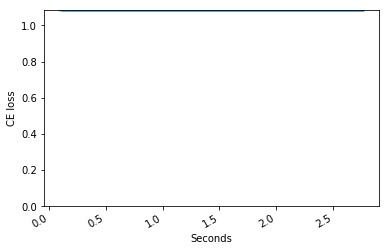

Training error 1.0806050337098863
Test error 1.115942343495102
Test accuracy 0.0


In [4]:
n_input = nFeatures
n_output = 3
hidden = [3]
FFN = FFN_MultiClass(n_input, n_output, hidden)
starttime = process_time()
FFN.fit(X_train,y_train,epochs=100, initialize = True,learning_rate=.01, display_loss=True)
# print(FFN.W)

y_test_preds = FFN.predict(X_test)
test_error = FFN.cross_entropy(y_test, y_test_preds)
print("Test error", test_error)

y_test_preds = (y_test_preds >= 0.5).astype("int")

score = accuracy_score(y_test_preds, y_test)
print("Test accuracy",score)


In [5]:
nFeatures = 13

data = pd.read_csv("data/wine - norm.csv", header=None)
array = data.values
X = array[:,0:nFeatures]
y = array[:,nFeatures:]

X_train, X_test, y_train, y_test = train_test_split(
                X, y, test_size=0.4, random_state=42)

# X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

print(X_train.shape, y_train.shape)
# print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(106, 13) (106, 3)
(72, 13) (72, 3)


In [6]:
class Position:
    
    def __init__(self, n_inputs, n_outputs, hidden_sizes):
        self.nx = n_inputs
        self.ny = n_outputs
        self.nh = len(hidden_sizes)
        self.sizes = [self.nx] + hidden_sizes + [self.ny]
        self.loss = 1000

        self.W = {}
        self.B = {}
        lo = -3
        hi = 3
        for i in range(self.nh + 1):
            
            self.W[i + 1] = np.random.uniform(lo, hi, (self.sizes[i], self.sizes[i + 1]) )
            self.B[i + 1] = np.ones((1, self.sizes[i + 1]))
    
    def relu(self, x):
        return np.where(x < 0, 0.0, x)
    
    def sigmoid(self, x):
        return 1/(1 + np.exp(-x)) 
    
    def softmax(self, x):
        exps = np.exp(x)
        return exps / np.sum(exps)
    
    def cross_entropy(self, label, pred):
        yl = np.multiply(pred, label)
        yl = yl[yl != 0]
        yl = -np.log(yl)
        yl = np.mean(yl)
        return yl
    
    def forward_pass(self, x):
        self.A = {}
        self.H = {}
        self.H[0] = x.reshape(1, -1)
        for i in range(self.nh):
            self.A[i + 1] = np.matmul(self.H[i], self.W[i + 1]) + self.B[i + 1]
            self.H[i + 1] = self.relu(self.A[i + 1])
        self.A[self.nh + 1] = np.matmul(self.H[self.nh], self.W[self.nh + 1]) + self.B[self.nh + 1]
        self.H[self.nh + 1] = self.softmax(self.A[self.nh + 1])
        
        return self.H[self.nh + 1]
    
    def predict(self, X):
        Y_pred = []
        for x in X:
            y_pred = self.forward_pass(x)
            Y_pred.append(y_pred)
        return np.array(Y_pred).squeeze()
    
    def calcFit(self, X, y):
        Y_pred = self.predict(X)
        self.loss = self.cross_entropy(y, Y_pred)
        
#         print(self.loss)
    
    def accuracy(self, X, y):
        y_preds = self.predict(X)
        y_preds = np.around(y_preds, decimals=3)
#         print(y_preds, y)
        y_preds = (y_preds >= 0.5).astype("int")
#         y_pred = np.argmax(logits, axis=1)
        score = accuracy_score(y_preds, y)
            
        return score

In [7]:
class Player:
    def __init__(self, n_inputs, n_outputs, hidden_sizes):
        self.now = Position(n_inputs, n_outputs, hidden_sizes)
        self.best = deepcopy(self.now)

#     r = rand.uniform()
    def delta(self, t, y, r):
        b = 30
        res = y * (1 - pow(r, pow( (1 - t/maxIterasi), b) ) )
        return res
    
    def moveOff(self, t, maxIter):
        UB = 1
        LB = -1
        
        for i in range(self.now.nh + 1):
            x = self.now.W[i + 1]
            r = rand.random() * 1
#             print(r)
            if(r <= 0.5):
                self.now.W[i + 1] = x + self.delta(t, UB - x, r)
            else:
                self.now.W[i + 1] = x - self.delta(t, x - LB, r)

    def moveForward(self, gbest):
        gama = 0.618
        alpha = (1 - gama) / 2
        beta = (1 - gama) / 2
        
        for i in range(self.now.nh + 1):
            x = self.now.W[i + 1]
            xb = self.best.W[i + 1]
            B = gbest.W[i + 1]

#             print("x : ", self.now.W[i + 1])
            self.now.W[i + 1] = (alpha * x + beta * xb + gama * B) / (alpha + beta + gama)
#             print(" jadi : ",  self.now.W[i + 1])
    

    

global  1.0474014550852067


1  global  0.8813562144186483
1  global  0.5648048362671944
1  global  0.48629959135146084
1  global  0.15804776554921934
2  global  0.15804776554921934
3  global  0.15641691038168354
3  global  0.1435585427976881
3  global  0.13266079649839488
4  global  0.13043630215099467
4  global  0.12336445196149504
5  global  0.12001682514983911
6  global  0.11963559892485244
6  global  0.11846856479327171
7  global  0.11759539937136972
7  global  0.11705355142207051
8  global  0.11623351816983471
9  global  0.1162335181698347
9  global  0.11618076364061097
10  global  0.11614969365548775


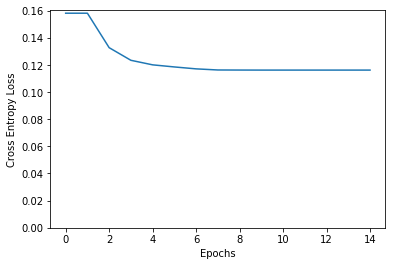

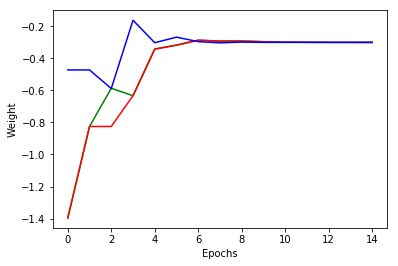

green = Player[1]nowWeight
red = Player[1]bestWeight
blue = global bestweight


In [14]:
players = []
n_input = 13
n_output = 3
hidden = [20]

dimensi = (n_input + n_output) * hidden[0]
numPlayer = dimensi
# numPlayer = 100
gbest = Position(n_input, n_output, hidden)

for i in range (numPlayer):
    p = Player(n_input, n_output, hidden)
    p.now.calcFit(X_train, y_train)
#     print("no : ", i, p.now.W)
    p.best = deepcopy(p.now)
    players.append(p)
    if(gbest.loss > p.best.loss):
        gbest = deepcopy(p.best)
print("global ", gbest.loss)

M = 0.3
L = 0.1
maxIterasi = 40
error = {}
weight = {}
weightPnow = {}
weightPbest = {}
weightG = {}
pCE = {}
stopcounter = 5
notUpdCnt = 0
for it in tqdm_notebook(range(maxIterasi), total=maxIterasi, unit="epoch"):
#     print("--------")
    it = it + 1
    for p in players:
        if(rand.random() < M):
            p.moveOff(it, maxIterasi)
            if(rand.random() < L):
                p.moveForward(gbest)
        else:
            p.moveForward(gbest)
    p1 = players[1]
#     print(p1.now.W[1])
    better = 0
    for p in players:
        p.now.calcFit(X_train, y_train)
        if( p.now.loss <= p.best.loss):
#             print("pbest ", pl.best.loss)
            p.best = deepcopy(p.now)
        if(p.now.loss <= gbest.loss):
            gbest = deepcopy(p.now)
            better = 1
            print(it, " global ", gbest.loss)
            
    if better :
        notUpdCnt = 0
    else : 
        notUpdCnt = notUpdCnt + 1
        
        
#     pCE[it] = players[1].now.loss
    weightPnow[it] = players[1].now.W[1][0][0]
    weightPbest[it] = players[1].best.W[1][0][0]
    weightG[it] = gbest.W[1][0][0]
    error[it] = gbest.loss
    
    if notUpdCnt == stopcounter :
        break
# print(error)

plt.plot(error.values())
# plt.plot(pCE.values(), color = 'red')
plt.xlabel('Epochs')
plt.ylabel('Cross Entropy Loss')
plt.ylim(bottom=0)
plt.show()


plt.plot(weightPnow.values(), color = 'green')
plt.plot(weightPbest.values(), color = 'red')
plt.plot(weightG.values(), color = 'blue')
plt.xlabel('Epochs')
plt.ylabel('Weight')
plt.show()
print( 'green = Player[1]nowWeight')
print( 'red = Player[1]bestWeight')
print( 'blue = global bestweight')



In [15]:
# print(gbest.W)

print(gbest.accuracy(X_train, y_train))

0.9716981132075472


In [26]:
def run():
    players = []
    n_input = 13
    n_output = 3
    hidden = [20]

    dimensi = (n_input + n_output) * hidden[0]
    numPlayer = dimensi
    # numPlayer = 100
    gbest = Position(n_input, n_output, hidden)

    for i in range (numPlayer):
        p = Player(n_input, n_output, hidden)
        p.now.calcFit(X_train, y_train)
    #     print("no : ", i, p.now.W)
        p.best = deepcopy(p.now)
        players.append(p)
        if(gbest.loss > p.best.loss):
            gbest = deepcopy(p.best)
#     print("global ", gbest.loss)

    M = 0.35
    L = 0.1
    maxIterasi = 40
    stopcounter = 5
    notUpdCnt = 0
    
    t1_start = process_time()  
    
    
    for it in tqdm_notebook(range(maxIterasi), total=maxIterasi, unit="epoch"):
    #     print("--------")
        it = it + 1
        for p in players:
            if(rand.random() < M):
                p.moveOff(it, maxIterasi)
                if(rand.random() < L):
                    p.moveForward(gbest)
            else:
                p.moveForward(gbest)
        p1 = players[1]
    #     print(p1.now.W[1])
        better = 0
        for p in players:
            p.now.calcFit(X_train, y_train)
            if( p.now.loss < p.best.loss):
    #             print("pbest ", pl.best.loss)
                p.best = deepcopy(p.now)
            if(p.now.loss < gbest.loss):
                gbest = deepcopy(p.now)
                better = 1
#                 print(it, " global ", gbest.loss)

        if better :
            notUpdCnt = 0
        else : 
            notUpdCnt = notUpdCnt + 1


    #     pCE[it] = players[1].now.loss


        if notUpdCnt == stopcounter :
            break
    
    t1_stop = process_time() 

    timeused = t1_stop-t1_start
    
#     print(gbest.loss)
#     print(gbest.accuracy(X_train, y_train))
#     print(timeused)

    gloss[ite] = gbest.loss
    acc[ite] = gbest.accuracy(X_train, y_train)
    testacc[ite] = gbest.accuracy(X_test, y_test)
    time[ite] = timeused
    

In [27]:
gloss = {}
acc = {}
time = {}
testacc = {}
for ite in range(5):
    run()

In [28]:
print(gloss)
print(acc)
print(time)
print(testacc)

{0: 0.17953080356710882, 1: 0.2778537202472437, 2: 0.19066509687402353, 3: 0.22477617688716184, 4: 0.3451244549342615}
{0: 0.9150943396226415, 1: 0.8867924528301887, 2: 0.9339622641509434, 3: 0.9245283018867925, 4: 0.839622641509434}
{0: 36.828125, 1: 47.375, 2: 71.328125, 3: 41.25, 4: 72.1875}
{0: 0.9305555555555556, 1: 0.8888888888888888, 2: 0.8888888888888888, 3: 0.9722222222222222, 4: 0.8333333333333334}


# IRIS

In [57]:
nFeatures = 4

data = pd.read_csv("data/iris-norm.csv", header=None)
array = data.values
X2 = array[:,0:nFeatures]
y2 = array[:,nFeatures:]

X2_train, X2_test, y2_train, y2_test = train_test_split(
                X2, y2, test_size=0.4, random_state=42)

In [67]:
players = []
n_input = nFeatures
n_output = 3
hidden = [10]

numPlayer = 100
gbest = Position(n_input, n_output, hidden)

for i in range (numPlayer):
    p = Player(n_input, n_output, hidden)
    p.now.calcFit(X2_train, y2_train)
#     print("no : ", i, p.now.W)
    p.best = deepcopy(p.now)
    players.append(p)
    if(gbest.loss > p.best.loss):
        gbest = deepcopy(p.best)
print("global ", gbest.loss)

M = 0.3
L = 0.05
maxIterasi = 100
error = {}
weight = {}
weightPnow = {}
weightPbest = {}
weightG = {}
pCE = {}
stopcounter = 5
notUpdCnt = 0

for it in tqdm_notebook(range(maxIterasi), total=maxIterasi, unit="epoch"):
#     print("--------")
    it = it + 1
    for p in players:
        if(rand.random() < M):
            p.moveOff(it, maxIterasi)
            if(rand.random() < L):
                p.moveForward(gbest)
        else:
            p.moveForward(gbest)
    p1 = players[1]
#     print(p1.now.W[1])
    better = 0
    for p in players:
        p.now.calcFit(X2_train, y2_train)
        if( p.now.loss <= p.best.loss):
#             print("pbest ", pl.best.loss)
            p.best = deepcopy(p.now)
        if(p.now.loss <= gbest.loss):
            gbest = deepcopy(p.now)
            better = 1
            print(it, " global ", gbest.loss)
            
    if better :
        notUpdCnt = 0
    else : 
        notUpdCnt = notUpdCnt + 1
    pCE[it] = players[1].now.loss
    weightPnow[it] = players[1].now.W[1][0][0]
    weightPbest[it] = players[1].best.W[1][0][0]
    weightG[it] = gbest.W[1][0][0]
    error[it] = gbest.loss
    if notUpdCnt == stopcounter : 
        break
    
# print(error)



global  0.9711389429243918


1  global  0.9197049471662323
2  global  0.9197049471662322
2  global  0.9175489959553654
3  global  0.9158330667258746
4  global  0.9158330667258746
5  global  0.9158330667258746


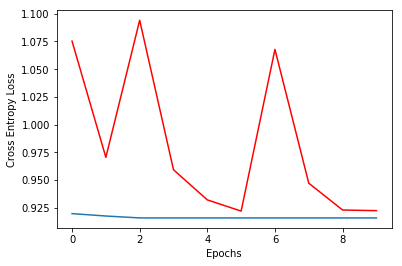

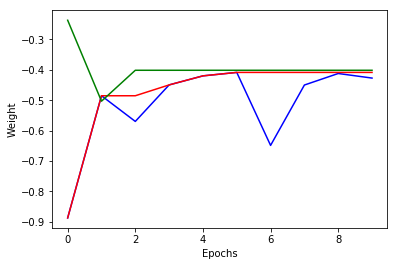

In [68]:
plt.plot(error.values())
plt.plot(pCE.values(), color = 'red')
plt.xlabel('Epochs')
plt.ylabel('Cross Entropy Loss')
plt.show()


plt.plot(weightPnow.values(), color = 'blue')
plt.plot(weightPbest.values(), color = 'red')
plt.plot(weightG.values(), color = 'green')
plt.xlabel('Epochs')
plt.ylabel('Weight')
plt.show()

# print(gbest.W)

In [66]:
print(gbest.accuracy(X2_test, y2_test))

[[0.42339223 0.3277907  0.24881707]
 [0.44531273 0.31742639 0.23726088]
 [0.22440211 0.34417517 0.43142272]
 [0.2280703  0.34934    0.4225897 ]
 [0.2668137  0.36631066 0.36687564]
 [0.2387543  0.34286356 0.41838214]
 [0.29505064 0.35243622 0.35251314]
 [0.31108254 0.35787233 0.33104514]
 [0.23896457 0.34853002 0.41250541]
 [0.41736655 0.33228427 0.25034918]
 [0.42586361 0.3245291  0.2496073 ]
 [0.28770267 0.34561688 0.36668044]
 [0.27974281 0.35226875 0.36798844]
 [0.29419116 0.35424064 0.3515682 ]
 [0.2377294  0.35434504 0.40792557]
 [0.22895795 0.33725193 0.43379012]
 [0.22864825 0.35602762 0.41532413]
 [0.25482687 0.35045657 0.39471656]
 [0.42699554 0.32675792 0.24624654]
 [0.24727202 0.34354592 0.40918206]
 [0.42787665 0.32504346 0.2470799 ]
 [0.26747844 0.34853404 0.38398752]
 [0.2333726  0.35030129 0.41632611]
 [0.42771437 0.31968958 0.25259605]
 [0.28613171 0.3526012  0.36126709]
 [0.30110969 0.35081036 0.34807995]
 [0.25653341 0.35004514 0.39342146]
 [0.40495718 0.33776817 0.25

In [26]:
players = []
n_input = nFeatures
n_output = 3
hidden = [2]

numPlayer =( n_input+n_output) * hidden[0]
gbest = Position(n_input, n_output, hidden)

for i in range (numPlayer):
    p = Player(n_input, n_output, hidden)
    p.now.calcFit(X2_train, y2_train)
#     print("no : ", i, p.now.W)
    p.best = deepcopy(p.now)
    players.append(p)
    if(gbest.loss > p.best.loss):
        gbest = deepcopy(p.best)
print("global ", gbest.loss)

M = 0.3
L = 0.05
maxIterasi = 100
error = {}
weight = {}
weightPnow = {}
weightPbest = {}
weightG = {}
pCE = {}
for it in tqdm_notebook(range(maxIterasi), total=maxIterasi, unit="epoch"):
#     print("--------")
    it = it + 1
    for p in players:
        if(rand.random() < M):
            p.moveOff(it, maxIterasi)
            if(rand.random() < L):
                p.moveForward(gbest)
        else:
            p.moveForward(gbest)
    p1 = players[1]
#     print(p1.now.W[1])
    for p in players:
        partial = X2_train[np.random.choice(X2_train.shape[0], 20, replace = False), :]
        p.now.calcFit(X2_train, y2_train)
        if( p.now.loss <= p.best.loss):
#             print("pbest ", pl.best.loss)
            p.best = deepcopy(p.now)
        if(p.now.loss <= gbest.loss):
            gbest = deepcopy(p.now)
            print(it, " global ", gbest.loss)
    pCE[it] = players[1].now.loss
    weightPnow[it] = players[1].now.W[1][0][0]
    weightPbest[it] = players[1].best.W[1][0][0]
    weightG[it] = gbest.W[1][0][0]
    error[it] = gbest.loss
    
# print(error)



global  0.9649282421205416


1  global  0.950088508984765
2  global  0.9043908690118647
3  global  0.9043908690118647
3  global  0.8901841327358664
4  global  0.8845590832264084
9  global  0.8845584915717091
10  global  0.8845584915717091
17  global  0.8844789319863127
33  global  0.8837938379980872
34  global  0.8837938379980872
35  global  0.8837938379980872
36  global  0.8837938379980872
37  global  0.8837938379980872
38  global  0.8837938379980872
46  global  0.8831182982879325
47  global  0.8831182982879325
48  global  0.8831182982879325
54  global  0.8831055978992355
55  global  0.8830993405511774
56  global  0.8830993405511774
57  global  0.8830993405511774
58  global  0.8830993405511774
59  global  0.8830993405511774
60  global  0.8830993405511774
61  global  0.8830993405511774
69  global  0.8830314923129907
70  global  0.8830314923129907
71  global  0.8830314923129907
72  global  0.8830314923129907



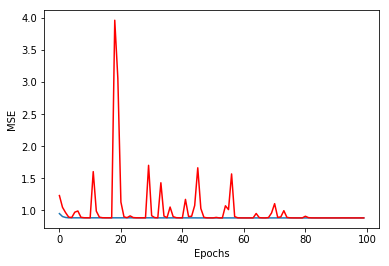

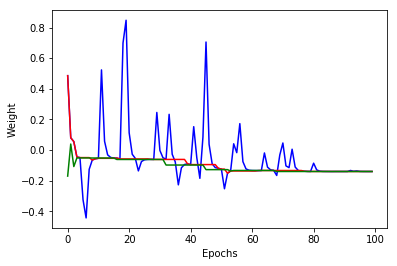

{1: array([[-0.14051004, -0.46722799],
       [-0.1094961 , -0.9897765 ],
       [-0.45627401, -0.18935994],
       [-1.256277  , -0.90259885]]), 2: array([[ 0.94192458, -0.24277376, -0.36556604],
       [ 1.24732235, -0.75444449, -0.3145964 ]])}


In [27]:
plt.plot(error.values())
plt.plot(pCE.values(), color = 'red')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.show()


plt.plot(weightPnow.values(), color = 'blue')
plt.plot(weightPbest.values(), color = 'red')
plt.plot(weightG.values(), color = 'green')
plt.xlabel('Epochs')
plt.ylabel('Weight')
plt.show()

print(gbest.W)

In [28]:
print(gbest.accuracy(X2_test, y2_test))

[[0.68857196 0.15441504 0.157013  ]
 [0.70095687 0.14877525 0.15026788]
 [0.33333333 0.33333333 0.33333333]
 [0.33333333 0.33333333 0.33333333]
 [0.36088661 0.31593824 0.32317515]
 [0.33333333 0.33333333 0.33333333]
 [0.33612174 0.33214393 0.33173434]
 [0.47345704 0.2585611  0.26798186]
 [0.33333333 0.33333333 0.33333333]
 [0.73603358 0.12812651 0.13583991]
 [0.69347419 0.15072059 0.15580522]
 [0.33333333 0.33333333 0.33333333]
 [0.33333333 0.33333333 0.33333333]
 [0.34498212 0.32834773 0.32667015]
 [0.33333333 0.33333333 0.33333333]
 [0.33333333 0.33333333 0.33333333]
 [0.33333333 0.33333333 0.33333333]
 [0.33333333 0.33333333 0.33333333]
 [0.7644914  0.11249578 0.12301282]
 [0.33333333 0.33333333 0.33333333]
 [0.70307241 0.14609522 0.15083237]
 [0.33333333 0.33333333 0.33333333]
 [0.33333333 0.33333333 0.33333333]
 [0.53182588 0.24355613 0.22461799]
 [0.33333333 0.33333333 0.33333333]
 [0.34132346 0.32991832 0.32875822]
 [0.33333333 0.33333333 0.33333333]
 [0.75431243 0.11721108 0.12